# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle

import glob
from sklearn.model_selection import train_test_split

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [4]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files


# train_data =torch.load('/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/train_data.pt')
# test_m_data =torch.load('/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/test_m_data.pt')
# test_w_data =torch.load('/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/test_w_data.pt')


# This code used to load the data on the first time, and save it.

import glob
paths = [f"/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/{path}/*.jpg" for path in ['train', 'test_m', 'test_w']]
 # TODO - UPDATE ME!

all_images = [0, 0, 0]
k=0
for path in paths:
  images = {}

  for file in glob.glob(path):
      filename = file.split("/")[-1]               # get the name of the .jpg file
      img = plt.imread(file)                       # read the image as a numpy array
      images[filename] = img[:, :, :3]/255 - 0.5   # remove the alpha channel
  images_1 = sorted(images.keys())
  data = np.zeros((len(images_1),3,2,224,224,3))
  all_pairs = []
  for i in range(0,len(images_1),6):
    curr_triplet = images_1[i:i+6]
    pairs = np.array([np.stack((np.array(images[curr_triplet[j*2]]), np.array(images[curr_triplet[j*2+1]])), axis=0) for j in range(3)])

    data[i,:,:,:,:,:] =pairs
    all_pairs.append(data[i,:,:,:,:,:])

  all_pairs = np.array(all_pairs)
  all_images[k] = all_pairs
  k+=1
  

In [5]:
# This code saves the data we loaded and processed.


all_images = np.array(all_images)
train_data = all_images[0]
test_m_data = all_images[1]
test_w_data = all_images[2]


torch.save(train_data, '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/train_data.pt')
torch.save(test_m_data, '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/test_m_data.pt')
torch.save(test_w_data, '/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/data/test_w_data.pt')

<ipython-input-5-c64eabd0f18e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_images = np.array(all_images)


In [6]:
# # This code used to understand how to show the images.

# image = train_data[4,0,0,:,:,:]

# print(image)

# min_value = image.min()
# max_value = image.max()

# # Clip the image to the valid range
# image = ((np.clip(image, 0, 255)+0.5)*255).astype(np.uint8)

# plt.imshow(image)

# print(image)

# plt.figure()
# plt.imshow(((train_data[4,0,0,:,:,:]+0.5)*255).astype(np.uint8))


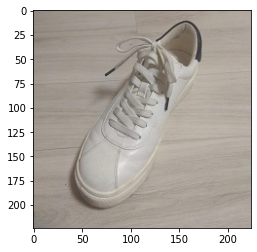

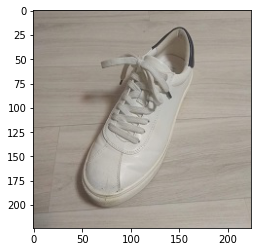

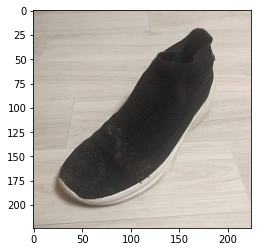

In [7]:
# Run this code, include the image in your PDF submission
modified_train_data = (train_data+0.5)

# print(train_data[4,0,0,:,:,:])
# print(modified_train_data[4,0,0,:,:,:])


plt.figure()
plt.imshow(modified_train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(modified_train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(modified_train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

In [8]:
train_data, validation_data = train_test_split(train_data, test_size=0.15)

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


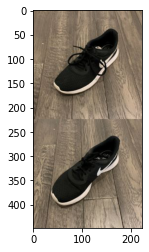

In [9]:
# Your code goes here

def generate_same_pair(data):
  left_shoes = data[:,0,0,:,:,:]
  right_shoes = data[:,0,1,:,:,:]
  full_arr = np.hstack((left_shoes, right_shoes))

  for i in range(1,3):
    left_shoes = data[:,i,0,:,:,:]
    right_shoes = data[:,i,1,:,:,:]
    combined = np.hstack((left_shoes, right_shoes))
    full_arr = np.vstack((full_arr, combined))
  return full_arr

# Run this code, include the result with your PDF submission
print(modified_train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(modified_train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(modified_train_data)[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


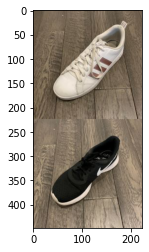

In [10]:
# Your code goes here

def generate_different_pair(data):
  permutations = np.array([(x, y) for x in [0, 1, 2] for y in [0, 1, 2] if x != y])
  num_of_students = np.shape(data)[0]
  full = []

  for student in range(num_of_students):
    np.random.shuffle(permutations)
    for pair in permutations[:-3]: 
      left_shoe = data[student][pair[0],0,:,:,:]
      right_shoe = data[student][pair[1],1,:,:,:]
      combined = np.vstack((left_shoe, right_shoe))
      full.append(combined)
 
  full = np.array(full)
  return full



# Run this code, include the result with your PDF submission
print(modified_train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(modified_train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(modified_train_data)[0]) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

The same person, takes all of his shoes photos on the same floor and with the same camera, therefore, the shoe backgroud is the same, and the photo resulution, lighting settings, and so on are relativly the same.

Our goal is to train the network to identify whether two shoes came from the same person or not. If we teach our model that different shoes that are not paired, also have different backgroud, lighting and so, we might teach it to differentiate between those parameters instead of the shoe itself.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

This could be a problem since our network might learn to only identify our data as the label corresponding to most of the data.

In the example above, if 99% of the data set are images not from the same pair, our model will be bias towords this answer. The will guess for every input that the shoes are not from the same pair, and will be right 99% of the times.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [11]:
class CNN(nn.Module):
    def __init__(self, n = 4, kernel_size = 5):
        super(CNN, self).__init__()
        # TODO: complete this method
        self.cnn1 = nn.Sequential( # 3x448x224
            nn.Conv2d(in_channels=3, out_channels = n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.cnn2 = nn.Sequential(# 3x224x112
            nn.Conv2d(in_channels = n, out_channels = 2*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.cnn3 = nn.Sequential(# 3x112x56
            nn.Conv2d(in_channels = 2*n, out_channels = 4*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.cnn4 = nn.Sequential(# 3x56x28
            nn.Conv2d(in_channels = 4*n, out_channels = 8*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )# 3x28x14
        self.fc1 = nn.Linear(8*n*14*28, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, inp):
        out = self.cnn1(inp)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = nn.LeakyReLU()(out)
        out = self.fc2(out)
        return out


### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [12]:
class CNNChannel(nn.Module):
    def __init__(self, n = 4, kernel_size = 4):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.cnn1 = nn.Sequential( # 6x224x224
            nn.Conv2d(in_channels = 6, out_channels = n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.cnn2 = nn.Sequential(# 6x112x112
            nn.Conv2d(in_channels = n, out_channels = 2*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.cnn3 = nn.Sequential(# 6x56x56
            nn.Conv2d(in_channels = 2*n, out_channels = 4*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.cnn4 = nn.Sequential(# 6x28x28
            nn.Conv2d(in_channels = 4*n, out_channels = 8*n, kernel_size = kernel_size, padding = (kernel_size-1)//2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )# 6x14x14
        self.fc1 = nn.Linear(8*n*14*14,100)
        
        self.fc2 = nn.Linear(100,2)

    # TODO: complete this class
    def forward(self, inp):
        # 3x448x224---># 6x224x224
        a1   = inp[:, :, :, 224:]
        a2   = inp[:, :, :, :224]
        inp2 = torch.cat((a1,a2),1)
        out = self.cnn1(inp2)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = nn.Flatten()(out)
        out = self.fc1(out)
        out = nn.LeakyReLU()(out)
        out = self.fc2(out)
        return out



## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

The strength of Both CNN models is to compare physically close areas of an image to one another. Therefor, for example, a white shoe is distinguished from its brown background easily.

Similarly, in the CNN Channel model by modeling the images as two separate layers, the images are "physically closer", as in the shoes in both images are "stacked" on top of one another. 

For this reason CNN channel is performing better than CNN.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

We wish to track false positive and false negative separately because they could imply different issues in our code or data set.

For example, if we get high false positive and low false negative it could imply that the data set is too similar (like all backgrounds or lighting are the same).

However, if we have high false negative and low false positive maybe we're overfitting the training set and might want to reevaluate that.

These are different symptoms to be treated with different measures, that we might have neglected if we only shoed false positive and false negative together. 

In [13]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.to("cpu")
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.to("cpu")
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [14]:
# Write your code here
from sklearn.utils import shuffle

def run_train(model,
              train_data,
              validation_data,
              batch_size=100,
              learning_rate=0.001,
              weight_decay=0,
              epochs=5,
              checkpoint_path='/content/gdrive/MyDrive/Colab Notebooks/Deep_Learning/ckpt_CNN_CHANNEL-{}.pk',
              save_best_model=False
              ):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
  if (save_best_model):
    best_epoch, best_pos_and_neg_avg_acc, best_neg_acc, best_pos_acc = 0, 0, 0, 0 #initilize variables for saving best model

  losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg  = [], [], [] ,[], []
  class_batch_size = int(batch_size/2)

  #create same pairs and different pair datasets
  train_data_pos = generate_same_pair(train_data)     
  train_data_neg = generate_different_pair(train_data)
  
  for epoch in range(epochs):
    loss_sum = 0
    #shuffling the positive and negative samples at the start of each epoch
    train_data_pos = shuffle(train_data_pos)
    train_data_neg = shuffle(train_data_neg)

    for i in range(0, len(train_data_pos), class_batch_size):
      if (i + class_batch_size) > len(train_data_pos):
            break

      # get the input and targets of a minibatch -create then as tensors
      xt_pos = torch.Tensor(train_data_pos[i:i+(class_batch_size)]).transpose(1, 3)
      st_pos = torch.ones((class_batch_size,), dtype=torch.long) 
      xt_neg = torch.Tensor(train_data_neg[i:i+(class_batch_size)]).transpose(1, 3)
      st_neg = torch.zeros((class_batch_size,), dtype=torch.long) 
      xt = torch.cat((xt_pos, xt_neg), 0)
      st = torch.cat((st_pos, st_neg), 0)

      # send to device
      xt, st = xt.to(device), st.to(device)      
      #print(device)    
      
      zs = model(xt)            # compute prediction logit
      loss = criterion(zs, st) # compute the total loss
      optimizer.zero_grad()     # zero the gradients before running the backward pass. a clean up step for PyTorch
      loss.backward()           # Backward pass to compute the gradient of loss w.r.t our learnable params. 
      optimizer.step()          # Update params

      loss_sum += loss

    
    # save the current training information
    num_of_training_samples = 2*i if (i + class_batch_size) > len(train_data_pos) else 2*len(train_data_pos)
    # compute *average* loss of epoch
    losses.append(float(loss_sum)/num_of_training_samples)  
    epoch_train_loss = float(loss_sum.detach().cpu().numpy())/num_of_training_samples
    
    # Train accuracy
    train_acc_pos, train_acc_neg = get_accuracy(model, train_data, batch_size)
    train_accs_pos.append(train_acc_pos)
    train_accs_neg.append(train_acc_neg)

    # Validation accuracy
    val_acc_pos, val_acc_neg = get_accuracy(model, validation_data, batch_size)
    val_accs_pos.append(val_acc_pos)
    val_accs_neg.append(val_acc_neg)

    print("epoch %d. [Val Acc (all %.0f%%), (positives %.0f%%), (negatives: %.0f%%)] [Train Acc (all %.0f%%), (positive: %.0f%%), (negatives: %.0f%%), Loss %f]" % (
          epoch, ((val_acc_pos+val_acc_neg)/2) * 100, val_acc_pos * 100, val_acc_neg * 100, ((train_acc_pos+train_acc_neg)/2) * 100,  train_acc_pos * 100, train_acc_neg * 100, epoch_train_loss))

    #save best model based of validation - if avarge is higher 
    if (save_best_model):
      if ((val_acc_pos+val_acc_neg)/2 > best_pos_and_neg_avg_acc):
        print("saving epoch", epoch, "as best epoch")
        best_pos_and_neg_avg_acc = (val_acc_pos+val_acc_neg)/2
        best_pos_acc, best_neg_acc = val_acc_pos, val_acc_neg
        best_epoch = epoch
        torch.save(model.state_dict(), checkpoint_path.format(epoch))
      elif ((val_acc_pos+val_acc_neg)/2 == best_pos_and_neg_avg_acc):
        if (abs(val_acc_pos-val_acc_neg) < abs(best_pos_acc-best_neg_acc)):
          print("saving epoch", epoch, "as best epoch")
          best_pos_acc, best_neg_acc = val_acc_pos, val_acc_neg
          best_epoch = epoch
          torch.save(model.state_dict(), checkpoint_path.format(epoch))

  return epochs, losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg


def plot_learning_curve(epochs, losses, train_accs_pos=None, val_accs_pos=None, train_accs_neg=None, val_accs_neg=None):
    """
    Plot the learning curve.
    """
    plt.title("Loss per epoch")
    plt.plot(range(epochs), losses, label="Train")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per epoch")

    train_accs_pos ,train_accs_neg = np.array(train_accs_pos), np.array(train_accs_neg)
    plt.plot(range(epochs), (train_accs_pos+train_accs_neg)/2, linewidth=2.1, label="Train average of postives and negatives")
    val_accs_pos, val_accs_neg = np.array(val_accs_pos), np.array(val_accs_neg)
    plt.plot(range(epochs), (val_accs_pos+val_accs_neg)/2,linewidth=2.1, label="Validation average of postives and negatives")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

epoch 0. [Val Acc (all 50%), (positives 100%), (negatives: 0%)] [Train Acc (all 50%), (positive: 100%), (negatives: 0%), Loss 0.173727]
epoch 1. [Val Acc (all 50%), (positives 0%), (negatives: 100%)] [Train Acc (all 47%), (positive: 0%), (negatives: 93%), Loss 0.173301]
epoch 2. [Val Acc (all 52%), (positives 94%), (negatives: 10%)] [Train Acc (all 57%), (positive: 87%), (negatives: 27%), Loss 0.173214]
epoch 3. [Val Acc (all 50%), (positives 94%), (negatives: 6%)] [Train Acc (all 57%), (positive: 100%), (negatives: 13%), Loss 0.173144]
epoch 4. [Val Acc (all 47%), (positives 4%), (negatives: 90%)] [Train Acc (all 50%), (positive: 7%), (negatives: 93%), Loss 0.173119]
epoch 5. [Val Acc (all 50%), (positives 100%), (negatives: 0%)] [Train Acc (all 53%), (positive: 93%), (negatives: 13%), Loss 0.172918]
epoch 6. [Val Acc (all 50%), (positives 94%), (negatives: 6%)] [Train Acc (all 50%), (positive: 93%), (negatives: 7%), Loss 0.172859]
epoch 7. [Val Acc (all 48%), (positives 88%), (negati

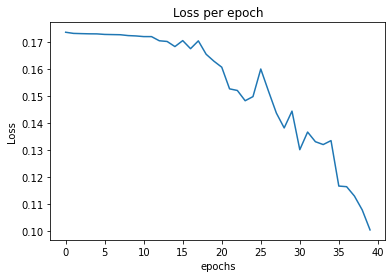

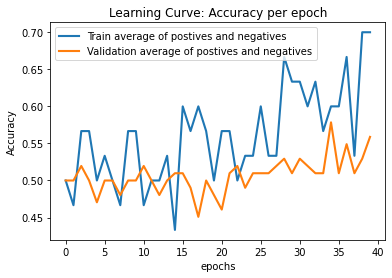

In [15]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy. 

# This part is for CNN - Q2a

cnn_model = CNN()
cnn_model.to(device)

epochs, losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg = run_train(cnn_model, 
                                                                                       train_data=train_data[:5], 
                                                                                       validation_data=validation_data, 
                                                                                       batch_size=5, learning_rate=0.00025, 
                                                                                       weight_decay=0.00045, 
                                                                                       epochs=40)
plot_learning_curve(epochs, 
                    losses, 
                    train_accs_pos=train_accs_pos, 
                    val_accs_pos=val_accs_pos, 
                    train_accs_neg=train_accs_neg, 
                    val_accs_neg=val_accs_neg)

(95, 3, 2, 224, 224, 3) (17, 3, 2, 224, 224, 3)
epoch 0. [Val Acc (all 49%), (positives 96%), (negatives: 2%)] [Train Acc (all 50%), (positive: 100%), (negatives: 0%), Loss 0.173381]
epoch 1. [Val Acc (all 49%), (positives 96%), (negatives: 2%)] [Train Acc (all 50%), (positive: 100%), (negatives: 0%), Loss 0.173247]
epoch 2. [Val Acc (all 50%), (positives 94%), (negatives: 6%)] [Train Acc (all 60%), (positive: 100%), (negatives: 20%), Loss 0.173107]
epoch 3. [Val Acc (all 53%), (positives 45%), (negatives: 61%)] [Train Acc (all 53%), (positive: 40%), (negatives: 67%), Loss 0.172948]
epoch 4. [Val Acc (all 49%), (positives 39%), (negatives: 59%)] [Train Acc (all 57%), (positive: 40%), (negatives: 73%), Loss 0.172653]
epoch 5. [Val Acc (all 46%), (positives 14%), (negatives: 78%)] [Train Acc (all 50%), (positive: 20%), (negatives: 80%), Loss 0.172329]
epoch 6. [Val Acc (all 44%), (positives 18%), (negatives: 71%)] [Train Acc (all 47%), (positive: 20%), (negatives: 73%), Loss 0.171254]
ep

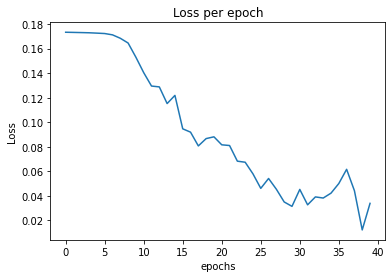

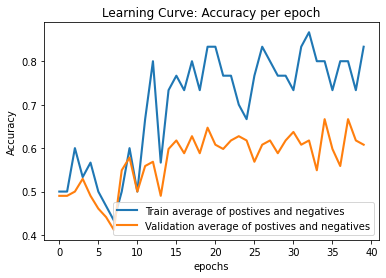

In [16]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy. 

# This part is for CNN channel - Q2b

CNN_ChannModel = CNNChannel(kernel_size=9)
CNN_ChannModel.to(device)
print(np.shape(train_data), np.shape(validation_data)) 

epochs, losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg = run_train(CNN_ChannModel, 
                                                                                       train_data=train_data[:5], 
                                                                                       validation_data=validation_data, 
                                                                                       batch_size=5, 
                                                                                       learning_rate=0.0001, 
                                                                                       weight_decay=0.00025, 
                                                                                       epochs=40)
plot_learning_curve(epochs, 
                    losses, 
                    train_accs_pos=train_accs_pos, 
                    val_accs_pos=val_accs_pos, 
                    train_accs_neg=train_accs_neg, 
                    val_accs_neg=val_accs_neg)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

To improve the model's performance, we first tested various learning rates ranging from 1e-6 to 0.1 in increments of 10. We found that the best results were achieved with learning rates in the range of 0.00001. 

Despite this, the model's accuracy on the validation data did not exceed 60%. We determined that this might be due to negative values being passed to the Relu activation function, which deactivates neurons. 

To address this issue, we changed the activation function to LeakyRelu, which improved the model's accuracy to around 70%. 

We also added weight decay of 0.0005 to address the issue of exploding gradients. 

Finally, we used a grid search to optimize the number of features and kernel size, similar to a previous assignment in the course. 

We observed that the CNN_CHANNEL model had a faster and more stable learning curve compared to the regular CNN. We believe this is because stacking samples on top of each other allows the model to learn from both the left and right shoes at the same time, which is more efficient.

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

epoch 0. [Val Acc (all 56%), (positives 22%), (negatives: 90%)] [Train Acc (all 52%), (positive: 27%), (negatives: 77%), Loss 0.013916]
saving epoch 0 as best epoch
epoch 1. [Val Acc (all 50%), (positives 0%), (negatives: 100%)] [Train Acc (all 50%), (positive: 0%), (negatives: 100%), Loss 0.013895]
epoch 2. [Val Acc (all 50%), (positives 0%), (negatives: 100%)] [Train Acc (all 50%), (positive: 0%), (negatives: 100%), Loss 0.013885]
epoch 3. [Val Acc (all 52%), (positives 24%), (negatives: 80%)] [Train Acc (all 52%), (positive: 19%), (negatives: 84%), Loss 0.013883]
epoch 4. [Val Acc (all 51%), (positives 41%), (negatives: 61%)] [Train Acc (all 52%), (positive: 44%), (negatives: 60%), Loss 0.013865]
epoch 5. [Val Acc (all 50%), (positives 61%), (negatives: 39%)] [Train Acc (all 51%), (positive: 60%), (negatives: 43%), Loss 0.013858]
epoch 6. [Val Acc (all 51%), (positives 6%), (negatives: 96%)] [Train Acc (all 49%), (positive: 6%), (negatives: 93%), Loss 0.013857]
epoch 7. [Val Acc (al

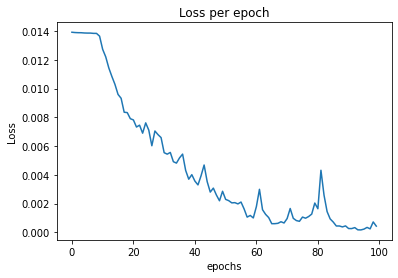

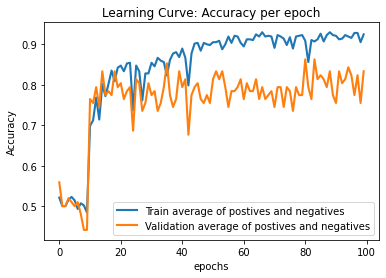

In [18]:
# Include the training curves for the two models.

CNN_model = CNN(n=24, kernel_size=15)
CNN_model.to(device)
#
epochs, losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg = run_train(CNN_model, 
                                                                                       train_data=train_data, 
                                                                                       validation_data=validation_data, 
                                                                                       batch_size=50, learning_rate=0.00005, 
                                                                                       weight_decay=0.0005, 
                                                                                       epochs=100,
                                                                                       save_best_model= True)
plot_learning_curve(epochs, 
                    losses, 
                    train_accs_pos=train_accs_pos, 
                    val_accs_pos=val_accs_pos, 
                    train_accs_neg=train_accs_neg, 
                    val_accs_neg=val_accs_neg)

epoch 0. [Val Acc (all 82%), (positives 82%), (negatives: 82%)] [Train Acc (all 81%), (positive: 84%), (negatives: 78%), Loss 0.141756]
saving epoch 0 as best epoch
epoch 1. [Val Acc (all 76%), (positives 73%), (negatives: 80%)] [Train Acc (all 81%), (positive: 85%), (negatives: 76%), Loss 0.122970]
epoch 2. [Val Acc (all 82%), (positives 78%), (negatives: 86%)] [Train Acc (all 84%), (positive: 86%), (negatives: 81%), Loss 0.119297]
epoch 3. [Val Acc (all 75%), (positives 55%), (negatives: 94%)] [Train Acc (all 78%), (positive: 61%), (negatives: 95%), Loss 0.097781]
epoch 4. [Val Acc (all 81%), (positives 84%), (negatives: 78%)] [Train Acc (all 82%), (positive: 88%), (negatives: 76%), Loss 0.093724]
epoch 5. [Val Acc (all 87%), (positives 84%), (negatives: 90%)] [Train Acc (all 86%), (positive: 87%), (negatives: 85%), Loss 0.095336]
saving epoch 5 as best epoch
epoch 6. [Val Acc (all 83%), (positives 80%), (negatives: 86%)] [Train Acc (all 87%), (positive: 87%), (negatives: 87%), Loss 

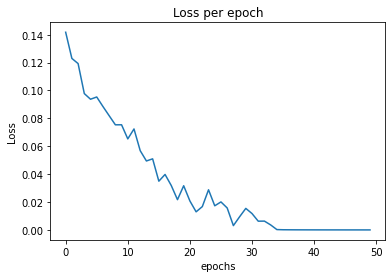

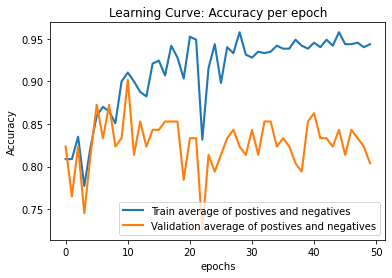

In [19]:
# Include the training curves for the two models.
CNN_model = CNNChannel(n=24, kernel_size=15)
CNN_model.to(device)
#
epochs, losses, train_accs_pos, val_accs_pos, train_accs_neg, val_accs_neg = run_train(CNN_model, 
                                                                                       train_data=train_data, 
                                                                                       validation_data=validation_data, 
                                                                                       batch_size=5, 
                                                                                       learning_rate=0.00005, 
                                                                                       weight_decay=0.00025, 
                                                                                       epochs=50,
                                                                                       save_best_model= True)
plot_learning_curve(epochs, 
                    losses, 
                    train_accs_pos=train_accs_pos, 
                    val_accs_pos=val_accs_pos, 
                    train_accs_neg=train_accs_neg,
                    val_accs_neg=val_accs_neg)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [22]:
# Write your code here. Make sure to include the test accuracy in your report
# CNN
CNN_model = CNN(n=24, kernel_size=15)
CNN_model.to(device)

CNN_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/CNN/ckpt_CNN_CHANNEL-83.pk')) 

test_accs_pos, test_accs_neg = get_accuracy(CNN_model,test_m_data)
print("CNN Test_men: [Accs (all %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_accs_pos+test_accs_neg)/2) * 100, test_accs_pos * 100, test_accs_neg * 100))

test_accs_pos, test_accs_neg = get_accuracy(CNN_model,test_w_data)
print("CNN Test_womem: [Accs (all %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_accs_pos+test_accs_neg)/2) * 100, test_accs_pos * 100, test_accs_neg * 100))

# CNN
CNNChannel_model = CNNChannel(n=24, kernel_size=15)
CNNChannel_model.to(device)

CNNChannel_model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/Deep_Learning/CNN_CHANNEL/ckpt_CNN_CHANNEL-10.pk')) 

test_accs_pos, test_accs_neg = get_accuracy(CNN_model,test_m_data)
print("CNN CHANNEL Test_men: [Accs (all %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_accs_pos+test_accs_neg)/2) * 100, test_accs_pos * 100, test_accs_neg * 100))

test_accs_pos, test_accs_neg = get_accuracy(CNN_model,test_w_data)
print("CNN CHANNEL Test_womem: [Accs (all %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_accs_pos+test_accs_neg)/2) * 100, test_accs_pos * 100, test_accs_neg * 100))

CNN Test_men: [Accs (all 68%), (positives 83%), (negatives: 53%)]
CNN Test_womem: [Accs (all 78%), (positives 83%), (negatives: 73%)]
CNN CHANNEL Test_men: [Accs (all 75%), (positives 83%), (negatives: 67%)]
CNN CHANNEL Test_womem: [Accs (all 72%), (positives 83%), (negatives: 60%)]


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

Following sample was labeled True as intended


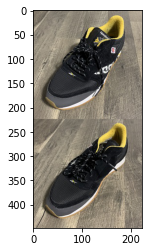

Following sample should have been labled False but was labeled True


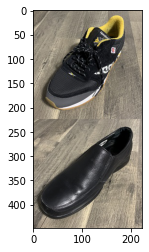

In [25]:
CNN_model.eval()
data_pos = generate_same_pair(test_m_data)     
data_neg = generate_different_pair(test_m_data) 

for i in range(np.shape(data_pos)[0]):
  xs = torch.Tensor(np.expand_dims(data_pos[i], axis=0)).transpose(1, 3)
  xs = xs.to(device)   
  zs = CNN_model(xs)
  pred = zs.max(1, keepdim=True)[1]
  if pred == True:
    print('Following sample was labeled True as intended')
    plt.imshow(((data_pos[i] + 0.5) * 255).astype(np.uint8)) 
    plt.show()
    break

for i in range(np.shape(data_neg)[0]):
  xs = torch.Tensor(np.expand_dims(data_neg[i], axis=0)).transpose(1, 3)
  xs = xs.to(device)   
  zs = CNN_model(xs)
  pred = zs.max(1, keepdim=True)[1]
  if pred == True:
    print('Following sample should have been labled False but was labeled True')
    plt.imshow(((data_neg[i] + 0.5) * 255).astype(np.uint8)) 
    plt.show()
    break


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Following sample was labeled True as intended


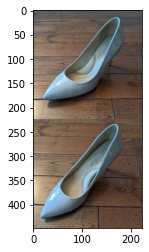

Following sample should have been labled False but was labeled True


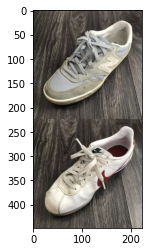

In [24]:
CNN_model.eval()
data_pos = generate_same_pair(test_w_data)   
data_neg = generate_different_pair(test_w_data)

for i in range(np.shape(data_pos)[0]):
  xs = torch.Tensor(np.expand_dims(data_pos[i], axis=0)).transpose(1, 3)
  xs = xs.to(device)   
  zs = CNN_model(xs)
  pred = zs.max(1, keepdim=True)[1]
  if pred == True:
    print('Following sample was labeled True as intended')
    plt.imshow(((data_pos[i] + 0.5) * 255).astype(np.uint8)) 
    plt.show()
    break

for i in range(np.shape(data_neg)[0]):
  xs = torch.Tensor(np.expand_dims(data_neg[i], axis=0)).transpose(1, 3)
  xs = xs.to(device)   
  zs = CNN_model(xs)
  pred = zs.max(1, keepdim=True)[1]
  if pred == True:
    print('Following sample should have been labled False but was labeled True')
    plt.imshow(((data_neg[i] + 0.5) * 255).astype(np.uint8)) 
    plt.show()
    break